# Regulation is important for velocity inference of RegVelo

## Library imports

In [1]:
import os
import sys
from tqdm import tqdm

import tensorflow
import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import accuracy_score
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

#from _calculation import get_gams
sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

2024-08-29 18:17:38.011518: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 18:17:42.153276: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 18:17:42.153534: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 18:17:42.158355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 18:17:43.117300: I tensorflow/core/platform/cpu_feature_g

In [2]:
from regvelovi import REGVELOVI
from typing import Literal
from velovi import preprocess_data, VELOVI
import anndata

In [3]:
import scipy
import sklearn
import unitvelo as utv
import re

import torch.nn.functional as F
from scipy.spatial.distance import cdist

(Running UniTVelo 0.2.5.2)
2024-08-29 16:22:39


## General settings

In [4]:
scvi.settings.dl_pin_memory_gpu_training = False

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [7]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'cell_cycle', exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'cell_cycle', exist_ok=True)

## Function definitions

In [8]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: add_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license

    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )

    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

In [9]:
def get_significance(pvalue):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: get_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license

    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [10]:
def add_regvelo_outputs_to_adata(adata_raw, vae, filter = False):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license

    latent_time = vae.get_latent_time(n_samples=30, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    ## calculate likelihood
    
    return adata

def GRN_Jacobian(reg_vae,Ms):
    net = reg_vae.module.v_encoder.fc1.weight.detach()
    bias = reg_vae.module.v_encoder.fc1.bias.detach() 
    max_rate = reg_vae.module.v_encoder.alpha_unconstr_max.detach()
    ## calculate the jacobian matrix respect to each cell
    Jaco_m = []
    for i in range(Ms.shape[0]):
        s = Ms[i,:]
        Jaco_m.append(reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach())
    Jaco_m = torch.stack(Jaco_m,2)
    return Jaco_m

## Data loading

In [11]:
adata = sc.read(DATA_DIR / "cell_cycle" / "cell_cycle_processed.h5ad")

In [12]:
adata.uns["regulators"] = adata.var.index.values
adata.uns["targets"] = adata.var.index.values
adata.uns["skeleton"] = np.ones((len(adata.var.index),len(adata.var.index)))
adata.uns["network"] = np.ones((len(adata.var.index),len(adata.var.index)))
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap', 'velocity_params', 'regulators', 'targets', 'skeleton', 'network'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

In [13]:
reg_vae = REGVELOVI.load(DATA_DIR / "cell_cycle" / "model_1",adata)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/cell_cycle/model_1/model.pt    
         already downloaded                                                                                        


## Fix the learned GRN (30 times)

In [14]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")

In [15]:
label = "phase"
cluster_edges = [
    ("G1", "S-ph"),
    ("S-ph", "G2M")]

In [16]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [17]:
score_v0 = []
score_t0 = []
for nrun in range(30):
    reg_vae_r1 = REGVELOVI(adata,W=W.T*0,soft_constraint = False)
    reg_vae_r1.module.v_encoder.fc1.weight.data = reg_vae.module.v_encoder.fc1.weight.data.detach().cpu().clone()
    reg_vae_r1.module.v_encoder.fc1.bias.data = reg_vae.module.v_encoder.fc1.bias.data.detach().cpu().clone()
    reg_vae_r1.train()
    
    adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_r1)
    
    scv.tl.velocity_graph(adata_target)
    adata_target.obsm["X_pca"] = adata.obsm["X_pca"].copy()
    scv.tl.velocity_embedding(adata_target, basis='pca')

    regvi = utv.evaluate(adata_target, cluster_edges, label, 'velocity', x_emb = 'X_pca')
    score_v0.append(np.mean([np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]))
    print(score_v0[len(score_v0)-1])
    
    ## calculate latent time correlation
    adata_target.obs["latent_time"] = np.mean(adata_target.layers["fit_t"],axis = 1)
    score_t0.append(scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["fucci_time"])[0])
    print(score_t0[len(score_t0)-1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1040/1500:  69%|██████▉   | 1040/1500 [05:43<02:31,  3.03it/s, loss=-729, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -898.876. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.23221782703168137, ('S-ph', 'G2M'): 0.21395316040534515}
Total Mean: 0.22308549371851327
# In-cluster Coherence
{'G1': 0.8648948, 'G2M': 0.94201803, 'N/A': 0.9054153, 'S-ph': 0.937335}
Total Mean: 0.9124158024787903
0.22308549371851327
0.5646263888099637


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1255/1500:  84%|████████▎ | 1255/1500 [07:08<01:23,  2.93it/s, loss=-770, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -925.619. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.24498918325641517, ('S-ph', 'G2M'): 0.2122649893620981}
Total Mean: 0.22862708630925663
# In-cluster Coherence
{'G1': 0.8534879, 'G2M': 0.94778657, 'N/A': 0.9049441, 'S-ph': 0.93824375}
Total Mean: 0.9111156463623047
0.22862708630925663
0.4962035410112718


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1500:  67%|██████▋   | 1000/1500 [05:51<02:55,  2.85it/s, loss=-753, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -910.933. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.21446663642823777, ('S-ph', 'G2M'): 0.20711023285759333}
Total Mean: 0.21078843464291555
# In-cluster Coherence
{'G1': 0.8561607, 'G2M': 0.95215523, 'N/A': 0.9082874, 'S-ph': 0.9433317}
Total Mean: 0.9149837493896484
0.21078843464291555
0.45692477806930054


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 959/1500:  64%|██████▍   | 959/1500 [05:54<03:20,  2.70it/s, loss=-731, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -894.815. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.21238778048333048, ('S-ph', 'G2M'): 0.20829231942518633}
Total Mean: 0.21034004995425842
# In-cluster Coherence
{'G1': 0.8573741, 'G2M': 0.9455876, 'N/A': 0.8995233, 'S-ph': 0.9330324}
Total Mean: 0.908879280090332
0.21034004995425842
0.5314561077434268


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1054/1500:  70%|███████   | 1054/1500 [06:07<02:35,  2.87it/s, loss=-737, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -908.236. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2318665527993433, ('S-ph', 'G2M'): 0.21000329906752496}
Total Mean: 0.2209349259334341
# In-cluster Coherence
{'G1': 0.85752946, 'G2M': 0.94584554, 'N/A': 0.90388596, 'S-ph': 0.9406778}
Total Mean: 0.9119847416877747
0.2209349259334341
0.5025324247571338


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1208/1500:  81%|████████  | 1208/1500 [06:42<01:37,  3.00it/s, loss=-771, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -922.949. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.23931574774313832, ('S-ph', 'G2M'): 0.20614875985420456}
Total Mean: 0.22273225379867145
# In-cluster Coherence
{'G1': 0.8489082, 'G2M': 0.95491654, 'N/A': 0.9075943, 'S-ph': 0.9417337}
Total Mean: 0.9132882356643677
0.22273225379867145
0.44193361452347996


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1036/1500:  69%|██████▉   | 1036/1500 [05:54<02:38,  2.92it/s, loss=-732, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -904.713. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.18250523777585978, ('S-ph', 'G2M'): 0.20114452162215823}
Total Mean: 0.19182487969900902
# In-cluster Coherence
{'G1': 0.8511345, 'G2M': 0.9365894, 'N/A': 0.89520174, 'S-ph': 0.9302536}
Total Mean: 0.9032948017120361
0.19182487969900902
0.4925936379044862


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 834/1500:  56%|█████▌    | 834/1500 [04:50<03:51,  2.87it/s, loss=-709, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -881.635. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2280760409572384, ('S-ph', 'G2M'): 0.20321966363760852}
Total Mean: 0.21564785229742345
# In-cluster Coherence
{'G1': 0.8595358, 'G2M': 0.9460748, 'N/A': 0.9048601, 'S-ph': 0.9410202}
Total Mean: 0.9128727316856384
0.21564785229742345
0.4532968168533308


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1139/1500:  76%|███████▌  | 1139/1500 [06:42<02:07,  2.83it/s, loss=-759, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -914.693. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.24749524021181332, ('S-ph', 'G2M'): 0.20996532710004703}
Total Mean: 0.22873028365593018
# In-cluster Coherence
{'G1': 0.8482026, 'G2M': 0.95260125, 'N/A': 0.9095792, 'S-ph': 0.9448253}
Total Mean: 0.9138021469116211
0.22873028365593018
0.4509795085484898


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 955/1500:  64%|██████▎   | 955/1500 [05:26<03:06,  2.92it/s, loss=-729, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -897.968. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.21203040967038342, ('S-ph', 'G2M'): 0.2013306882873308}
Total Mean: 0.20668054897885713
# In-cluster Coherence
{'G1': 0.8484992, 'G2M': 0.95140827, 'N/A': 0.89811784, 'S-ph': 0.9413363}
Total Mean: 0.9098403453826904
0.20668054897885713
0.3608161268481112


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1209/1500:  81%|████████  | 1209/1500 [06:47<01:38,  2.96it/s, loss=-767, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -920.581. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.23036932555164338, ('S-ph', 'G2M'): 0.2049917455738439}
Total Mean: 0.21768053556274364
# In-cluster Coherence
{'G1': 0.8438989, 'G2M': 0.9520533, 'N/A': 0.90380454, 'S-ph': 0.94259423}
Total Mean: 0.910587728023529
0.21768053556274364
0.4097931388299404


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1059/1500:  71%|███████   | 1059/1500 [06:08<02:33,  2.88it/s, loss=-736, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -902.775. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.23382314635342438, ('S-ph', 'G2M'): 0.20043556767974882}
Total Mean: 0.2171293570165866
# In-cluster Coherence
{'G1': 0.85187894, 'G2M': 0.9485794, 'N/A': 0.897912, 'S-ph': 0.93558526}
Total Mean: 0.908488929271698
0.2171293570165866
0.47135430055371486


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1184/1500:  79%|███████▉  | 1184/1500 [06:49<01:49,  2.89it/s, loss=-765, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -921.918. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.22214602054636468, ('S-ph', 'G2M'): 0.2072878793365886}
Total Mean: 0.21471694994147664
# In-cluster Coherence
{'G1': 0.8438958, 'G2M': 0.948716, 'N/A': 0.89674443, 'S-ph': 0.93496597}
Total Mean: 0.9060806035995483
0.21471694994147664
0.4871197019761055


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1091/1500:  73%|███████▎  | 1091/1500 [06:18<02:21,  2.88it/s, loss=-761, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -915.690. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2340791118404142, ('S-ph', 'G2M'): 0.20963234354410515}
Total Mean: 0.22185572769225967
# In-cluster Coherence
{'G1': 0.8515226, 'G2M': 0.95058316, 'N/A': 0.9028301, 'S-ph': 0.9386518}
Total Mean: 0.9108969569206238
0.22185572769225967
0.45302142647432114


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 991/1500:  66%|██████▌   | 991/1500 [05:24<02:46,  3.05it/s, loss=-728, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -901.800. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.23764393240916049, ('S-ph', 'G2M'): 0.20887497439258845}
Total Mean: 0.22325945340087447
# In-cluster Coherence
{'G1': 0.8520422, 'G2M': 0.9480127, 'N/A': 0.9057991, 'S-ph': 0.9425508}
Total Mean: 0.912101149559021
0.22325945340087447
0.4658401043972364


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1144/1500:  76%|███████▋  | 1144/1500 [06:42<02:05,  2.84it/s, loss=-762, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -916.791. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.22019193206870855, ('S-ph', 'G2M'): 0.21022699168842252}
Total Mean: 0.21520946187856554
# In-cluster Coherence
{'G1': 0.86159724, 'G2M': 0.9479326, 'N/A': 0.90654474, 'S-ph': 0.9410651}
Total Mean: 0.914284884929657
0.21520946187856554
0.4762169230024326


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1042/1500:  69%|██████▉   | 1042/1500 [06:03<02:39,  2.87it/s, loss=-736, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -903.903. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.25098560868111897, ('S-ph', 'G2M'): 0.20363803538583322}
Total Mean: 0.2273118220334761
# In-cluster Coherence
{'G1': 0.8438079, 'G2M': 0.9531758, 'N/A': 0.8993628, 'S-ph': 0.93682826}
Total Mean: 0.9082937240600586
0.2273118220334761
0.5479753719665211


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1167/1500:  78%|███████▊  | 1167/1500 [06:47<01:56,  2.86it/s, loss=-749, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -908.740. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.20596772196684385, ('S-ph', 'G2M'): 0.20518611770122433}
Total Mean: 0.2055769198340341
# In-cluster Coherence
{'G1': 0.8599617, 'G2M': 0.9444619, 'N/A': 0.90163374, 'S-ph': 0.93395007}
Total Mean: 0.9100018739700317
0.2055769198340341
0.42336793974148856


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1032/1500:  69%|██████▉   | 1032/1500 [05:42<02:35,  3.01it/s, loss=-740, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -909.665. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.24525439840325106, ('S-ph', 'G2M'): 0.21083490836120788}
Total Mean: 0.22804465338222946
# In-cluster Coherence
{'G1': 0.84805954, 'G2M': 0.95020163, 'N/A': 0.9004205, 'S-ph': 0.9390451}
Total Mean: 0.9094316959381104
0.22804465338222946
0.48212932331949093


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1189/1500:  79%|███████▉  | 1189/1500 [07:03<01:50,  2.81it/s, loss=-748, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -918.206. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.248246067364665, ('S-ph', 'G2M'): 0.2100537926620079}
Total Mean: 0.22914993001333644
# In-cluster Coherence
{'G1': 0.8555451, 'G2M': 0.9480296, 'N/A': 0.90738666, 'S-ph': 0.9417546}
Total Mean: 0.9131789803504944
0.22914993001333644
0.5303320026283046


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1095/1500:  73%|███████▎  | 1095/1500 [06:19<02:20,  2.89it/s, loss=-729, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -905.435. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.22917432701100043, ('S-ph', 'G2M'): 0.2079282345148487}
Total Mean: 0.21855128076292457
# In-cluster Coherence
{'G1': 0.851872, 'G2M': 0.9415186, 'N/A': 0.89620376, 'S-ph': 0.9336412}
Total Mean: 0.9058088660240173
0.21855128076292457
0.4854508140636082


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1016/1500:  68%|██████▊   | 1016/1500 [05:49<02:46,  2.91it/s, loss=-738, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -901.100. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2291668705302185, ('S-ph', 'G2M'): 0.20494271044728668}
Total Mean: 0.2170547904887526
# In-cluster Coherence
{'G1': 0.85224843, 'G2M': 0.9473178, 'N/A': 0.9025485, 'S-ph': 0.9383641}
Total Mean: 0.9101197123527527
0.2170547904887526
0.45550472698991856


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1024/1500:  68%|██████▊   | 1024/1500 [05:40<02:38,  3.00it/s, loss=-741, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -904.995. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2447188485986888, ('S-ph', 'G2M'): 0.20776749580846177}
Total Mean: 0.2262431722035753
# In-cluster Coherence
{'G1': 0.85768473, 'G2M': 0.954841, 'N/A': 0.9109631, 'S-ph': 0.943323}
Total Mean: 0.9167029857635498
0.2262431722035753
0.45129921348702395


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1167/1500:  78%|███████▊  | 1167/1500 [06:15<01:47,  3.11it/s, loss=-754, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -914.327. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.24730381851368205, ('S-ph', 'G2M'): 0.20855583018260926}
Total Mean: 0.22792982434814565
# In-cluster Coherence
{'G1': 0.8550112, 'G2M': 0.9494101, 'N/A': 0.9067707, 'S-ph': 0.9416382}
Total Mean: 0.9132075905799866
0.22792982434814565
0.44022764278704607


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 993/1500:  66%|██████▌   | 993/1500 [05:08<02:37,  3.22it/s, loss=-739, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -905.246. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.20775727941565245, ('S-ph', 'G2M'): 0.20564950876884622}
Total Mean: 0.20670339409224933
# In-cluster Coherence
{'G1': 0.8521427, 'G2M': 0.9504664, 'N/A': 0.90151584, 'S-ph': 0.9372185}
Total Mean: 0.9103358387947083
0.20670339409224933
0.4389651164777454


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1108/1500:  74%|███████▍  | 1108/1500 [06:17<02:13,  2.94it/s, loss=-742, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -910.831. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.21833376180292852, ('S-ph', 'G2M'): 0.2044570863490886}
Total Mean: 0.21139542407600856
# In-cluster Coherence
{'G1': 0.84602284, 'G2M': 0.95226103, 'N/A': 0.89997476, 'S-ph': 0.9406743}
Total Mean: 0.909733235836029
0.21139542407600856
0.42736797903172374


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1090/1500:  73%|███████▎  | 1090/1500 [06:11<02:19,  2.94it/s, loss=-747, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -911.023. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.22425398506561492, ('S-ph', 'G2M'): 0.21522776135920402}
Total Mean: 0.21974087321240948
# In-cluster Coherence
{'G1': 0.8540741, 'G2M': 0.94637203, 'N/A': 0.90357476, 'S-ph': 0.94145393}
Total Mean: 0.911368727684021
0.21974087321240948
0.4804854579828803


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1157/1500:  77%|███████▋  | 1157/1500 [06:24<01:54,  3.01it/s, loss=-747, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -903.069. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2226585836962245, ('S-ph', 'G2M'): 0.2079075819024223}
Total Mean: 0.2152830827993234
# In-cluster Coherence
{'G1': 0.8574815, 'G2M': 0.9453637, 'N/A': 0.90188956, 'S-ph': 0.9375404}
Total Mean: 0.9105688333511353
0.2152830827993234
0.47895039978769466


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1064/1500:  71%|███████   | 1064/1500 [05:43<02:20,  3.10it/s, loss=-739, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -904.829. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.22342395135943796, ('S-ph', 'G2M'): 0.20686485565897458}
Total Mean: 0.21514440350920627
# In-cluster Coherence
{'G1': 0.8567795, 'G2M': 0.9497695, 'N/A': 0.9043414, 'S-ph': 0.94299775}
Total Mean: 0.913472056388855
0.21514440350920627
0.46656463887385596


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 892/1500:  59%|█████▉    | 892/1500 [04:58<03:23,  2.99it/s, loss=-720, v_num=1]   
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -896.905. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.23049017117821607, ('S-ph', 'G2M'): 0.2085830049368876}
Total Mean: 0.21953658805755183
# In-cluster Coherence
{'G1': 0.85452145, 'G2M': 0.9493586, 'N/A': 0.9075084, 'S-ph': 0.941971}
Total Mean: 0.9133398532867432
0.21953658805755183
0.4849638961252132


In [18]:
score_v = []
dfs = []
score_t = []
for nrun in range(30):
    original_tensor = reg_vae.module.v_encoder.fc1.weight.data.detach().cpu().clone()
    original_shape = original_tensor.shape
    # Flatten the tensor
    flattened_tensor = original_tensor.flatten()
    # Generate a random permutation of indices
    permutation = torch.randperm(flattened_tensor.size(0))
    # Shuffle the flattened tensor using the permutation
    shuffled_flattened_tensor = flattened_tensor[permutation]

    permutation = torch.randperm(flattened_tensor.size(0))
    shuffled_flattened_tensor = shuffled_flattened_tensor[permutation]
    # Reshape the shuffled tensor back to the original shape
    shuffled_tensor = shuffled_flattened_tensor.reshape(original_shape)
    
    reg_vae_r1 = REGVELOVI(adata,W=W.T*0,soft_constraint = False)
    reg_vae_r1.module.v_encoder.fc1.weight.data = shuffled_tensor
    reg_vae_r1.module.v_encoder.fc1.bias.data = reg_vae.module.v_encoder.fc1.bias.data.detach().cpu().clone()
    reg_vae_r1.train()
    
    adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_r1)
    
    scv.tl.velocity_graph(adata_target)
    adata_target.obsm["X_pca"] = adata.obsm["X_pca"].copy()
    scv.tl.velocity_embedding(adata_target, basis='pca')

    regvi = utv.evaluate(adata_target, cluster_edges, label, 'velocity', x_emb = 'X_pca')
    score_v.append(np.mean([np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]))
    print(score_v[len(score_v)-1])
    
    ## calculate latent time correlation
    adata_target.obs["latent_time"] = np.mean(adata_target.layers["fit_t"],axis = 1)
    score_t.append(scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["fucci_time"])[0])
    print(score_t[len(score_t)-1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1045/1500:  70%|██████▉   | 1045/1500 [05:37<02:26,  3.10it/s, loss=-462, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -687.045. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.116648544891723, ('S-ph', 'G2M'): 0.16921325652248503}
Total Mean: 0.142930900707104
# In-cluster Coherence
{'G1': 0.9166625, 'G2M': 0.9456628, 'N/A': 0.94289005, 'S-ph': 0.94945025}
Total Mean: 0.9386664032936096
0.142930900707104
0.1706659636136195


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 861/1500:  57%|█████▋    | 861/1500 [04:34<03:23,  3.14it/s, loss=-448, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -681.890. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14493390003467785, ('S-ph', 'G2M'): 0.17659375682496437}
Total Mean: 0.16076382842982112
# In-cluster Coherence
{'G1': 0.9159379, 'G2M': 0.95152664, 'N/A': 0.94745135, 'S-ph': 0.9584522}
Total Mean: 0.9433420300483704
0.16076382842982112
-0.021831167531190167


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 932/1500:  62%|██████▏   | 932/1500 [05:16<03:13,  2.94it/s, loss=-449, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -680.906. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.08869808013038681, ('S-ph', 'G2M'): 0.12410492794123322}
Total Mean: 0.10640150403581002
# In-cluster Coherence
{'G1': 0.9064415, 'G2M': 0.9428479, 'N/A': 0.9348247, 'S-ph': 0.94643354}
Total Mean: 0.9326369166374207
0.10640150403581002
-0.34030608473332835


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1098/1500:  73%|███████▎  | 1098/1500 [05:57<02:11,  3.07it/s, loss=-473, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -688.942. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2045624536219609, ('S-ph', 'G2M'): 0.20839457191272254}
Total Mean: 0.20647851276734172
# In-cluster Coherence
{'G1': 0.91483426, 'G2M': 0.94541806, 'N/A': 0.94280183, 'S-ph': 0.9457768}
Total Mean: 0.937207818031311
0.20647851276734172
0.5006470399509617


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 924/1500:  62%|██████▏   | 924/1500 [05:28<03:24,  2.82it/s, loss=-468, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -701.259. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.13287007097552783, ('S-ph', 'G2M'): 0.20124292599683272}
Total Mean: 0.16705649848618026
# In-cluster Coherence
{'G1': 0.92007357, 'G2M': 0.94851327, 'N/A': 0.9439252, 'S-ph': 0.94991416}
Total Mean: 0.9406065344810486
0.16705649848618026
0.026466936016590174


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 877/1500:  58%|█████▊    | 877/1500 [05:22<03:48,  2.72it/s, loss=-478, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -702.784. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.08505486439682897, ('S-ph', 'G2M'): 0.1967939994312302}
Total Mean: 0.1409244319140296
# In-cluster Coherence
{'G1': 0.9101043, 'G2M': 0.9450733, 'N/A': 0.9410635, 'S-ph': 0.95064485}
Total Mean: 0.9367215633392334
0.1409244319140296
-0.09423094352376438


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 923/1500:  62%|██████▏   | 923/1500 [05:17<03:18,  2.90it/s, loss=-467, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -698.829. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.15492963611375102, ('S-ph', 'G2M'): 0.18540660404164927}
Total Mean: 0.17016812007770016
# In-cluster Coherence
{'G1': 0.91325796, 'G2M': 0.94239604, 'N/A': 0.9439426, 'S-ph': 0.94823104}
Total Mean: 0.9369568824768066
0.17016812007770016
0.18462721892126155


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 799/1500:  53%|█████▎    | 799/1500 [04:36<04:02,  2.89it/s, loss=-460, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -689.451. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.17534295612583442, ('S-ph', 'G2M'): 0.172623704737858}
Total Mean: 0.17398333043184622
# In-cluster Coherence
{'G1': 0.9200079, 'G2M': 0.95080084, 'N/A': 0.9459471, 'S-ph': 0.9537359}
Total Mean: 0.9426229000091553
0.17398333043184622
0.018022417954632174


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 871/1500:  58%|█████▊    | 871/1500 [04:51<03:30,  2.99it/s, loss=-440, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -675.955. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.0223171798324517, ('S-ph', 'G2M'): 0.17543890304842974}
Total Mean: 0.09887804144044073
# In-cluster Coherence
{'G1': 0.89997995, 'G2M': 0.9420071, 'N/A': 0.92991203, 'S-ph': 0.94058895}
Total Mean: 0.9281220436096191
0.09887804144044073
-0.5363707718819845


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 784/1500:  52%|█████▏    | 784/1500 [04:10<03:48,  3.13it/s, loss=-436, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -683.632. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.11908090443091268, ('S-ph', 'G2M'): 0.19586187950388406}
Total Mean: 0.15747139196739837
# In-cluster Coherence
{'G1': 0.9078507, 'G2M': 0.95194906, 'N/A': 0.9432654, 'S-ph': 0.9431183}
Total Mean: 0.9365458488464355
0.15747139196739837
0.28668658676900294


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 950/1500:  63%|██████▎   | 950/1500 [05:10<02:59,  3.06it/s, loss=-466, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -690.966. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.11548983808259168, ('S-ph', 'G2M'): 0.1661409213223729}
Total Mean: 0.14081537970248229
# In-cluster Coherence
{'G1': 0.9165381, 'G2M': 0.95168364, 'N/A': 0.9442011, 'S-ph': 0.9504091}
Total Mean: 0.9407079815864563
0.14081537970248229
0.0830635189081407


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1023/1500:  68%|██████▊   | 1023/1500 [05:19<02:28,  3.20it/s, loss=-478, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -697.809. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.20336035101360092, ('S-ph', 'G2M'): 0.2097632651055451}
Total Mean: 0.20656180805957303
# In-cluster Coherence
{'G1': 0.9170483, 'G2M': 0.95319784, 'N/A': 0.9462687, 'S-ph': 0.956136}
Total Mean: 0.943162739276886
0.20656180805957303
0.38507616531331396


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 920/1500:  61%|██████▏   | 920/1500 [05:12<03:16,  2.95it/s, loss=-453, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -680.476. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.08318139351941613, ('S-ph', 'G2M'): 0.19236478631274137}
Total Mean: 0.13777308991607876
# In-cluster Coherence
{'G1': 0.8973595, 'G2M': 0.9412519, 'N/A': 0.9345318, 'S-ph': 0.9486322}
Total Mean: 0.9304438829421997
0.13777308991607876
0.11298035778658072


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 948/1500:  63%|██████▎   | 948/1500 [05:14<03:02,  3.02it/s, loss=-467, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -688.030. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14857652981026453, ('S-ph', 'G2M'): 0.1912806821100235}
Total Mean: 0.16992860596014403
# In-cluster Coherence
{'G1': 0.901826, 'G2M': 0.9438404, 'N/A': 0.9348441, 'S-ph': 0.94649565}
Total Mean: 0.9317514896392822
0.16992860596014403
0.28785439592508


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 923/1500:  62%|██████▏   | 923/1500 [05:18<03:19,  2.90it/s, loss=-465, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -703.725. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.11948984159063804, ('S-ph', 'G2M'): 0.1969623336113933}
Total Mean: 0.15822608760101567
# In-cluster Coherence
{'G1': 0.9137277, 'G2M': 0.9397878, 'N/A': 0.9364744, 'S-ph': 0.94733536}
Total Mean: 0.9343312978744507
0.15822608760101567
0.20774972397187447


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 836/1500:  56%|█████▌    | 836/1500 [04:47<03:48,  2.91it/s, loss=-436, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -680.187. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.02386967018528004, ('S-ph', 'G2M'): 0.19184207840231438}
Total Mean: 0.10785587429379721
# In-cluster Coherence
{'G1': 0.8960617, 'G2M': 0.94979584, 'N/A': 0.93166494, 'S-ph': 0.9540117}
Total Mean: 0.9328835606575012
0.10785587429379721
0.5215286227767735


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 898/1500:  60%|█████▉    | 898/1500 [04:59<03:20,  3.00it/s, loss=-458, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -696.877. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.05458822331653668, ('S-ph', 'G2M'): 0.13804667388703304}
Total Mean: 0.09631744860178486
# In-cluster Coherence
{'G1': 0.91332215, 'G2M': 0.9379536, 'N/A': 0.9390835, 'S-ph': 0.9449775}
Total Mean: 0.9338341951370239
0.09631744860178486
-0.3987105728049765


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 970/1500:  65%|██████▍   | 970/1500 [05:16<02:53,  3.06it/s, loss=-478, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -696.075. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.07358778063524107, ('S-ph', 'G2M'): 0.14359696051182483}
Total Mean: 0.10859237057353295
# In-cluster Coherence
{'G1': 0.91275185, 'G2M': 0.9478248, 'N/A': 0.9412301, 'S-ph': 0.9491874}
Total Mean: 0.9377485513687134
0.10859237057353295
-0.05799416901615596


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 975/1500:  65%|██████▌   | 975/1500 [05:07<02:45,  3.17it/s, loss=-452, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -691.269. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.09700872950485286, ('S-ph', 'G2M'): 0.1848691694899765}
Total Mean: 0.14093894949741467
# In-cluster Coherence
{'G1': 0.9064893, 'G2M': 0.947022, 'N/A': 0.94154906, 'S-ph': 0.9489218}
Total Mean: 0.9359955787658691
0.14093894949741467
-0.06713047613602285


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 798/1500:  53%|█████▎    | 798/1500 [04:27<03:55,  2.98it/s, loss=-470, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -703.983. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.179086217073029, ('S-ph', 'G2M'): 0.2159390634091914}
Total Mean: 0.1975126402411102
# In-cluster Coherence
{'G1': 0.89938885, 'G2M': 0.952705, 'N/A': 0.9377362, 'S-ph': 0.95259494}
Total Mean: 0.9356063008308411
0.1975126402411102
0.17848337017871896


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1070/1500:  71%|███████▏  | 1070/1500 [05:49<02:20,  3.06it/s, loss=-494, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -702.563. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.2177533063367078, ('S-ph', 'G2M'): 0.19213034705054502}
Total Mean: 0.20494182669362643
# In-cluster Coherence
{'G1': 0.9157518, 'G2M': 0.9505283, 'N/A': 0.9458506, 'S-ph': 0.9522415}
Total Mean: 0.9410930275917053
0.20494182669362643
0.20555851111059747


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 777/1500:  52%|█████▏    | 777/1500 [04:30<04:12,  2.87it/s, loss=-462, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -693.824. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.057162310036622054, ('S-ph', 'G2M'): 0.19324203776577142}
Total Mean: 0.12520217390119673
# In-cluster Coherence
{'G1': 0.9103854, 'G2M': 0.9529363, 'N/A': 0.9424057, 'S-ph': 0.95762074}
Total Mean: 0.940837025642395
0.12520217390119673
0.05082397137354895


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 941/1500:  63%|██████▎   | 941/1500 [05:41<03:22,  2.76it/s, loss=-444, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -693.690. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.12014822548924091, ('S-ph', 'G2M'): 0.19858929802351455}
Total Mean: 0.15936876175637774
# In-cluster Coherence
{'G1': 0.910696, 'G2M': 0.94139993, 'N/A': 0.93962765, 'S-ph': 0.9486652}
Total Mean: 0.9350972175598145
0.15936876175637774
0.4185619700290196


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 934/1500:  62%|██████▏   | 934/1500 [04:51<02:56,  3.20it/s, loss=-471, v_num=1]   
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -703.690. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.1771925214361928, ('S-ph', 'G2M'): 0.20577773148697942}
Total Mean: 0.1914851264615861
# In-cluster Coherence
{'G1': 0.92787826, 'G2M': 0.9480927, 'N/A': 0.94608605, 'S-ph': 0.95357865}
Total Mean: 0.9439089298248291
0.1914851264615861
0.12181449790348475


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 975/1500:  65%|██████▌   | 975/1500 [05:02<02:43,  3.22it/s, loss=-476, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -703.723. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.19954111154430765, ('S-ph', 'G2M'): 0.1855748996885288}
Total Mean: 0.19255800561641823
# In-cluster Coherence
{'G1': 0.91627246, 'G2M': 0.95089674, 'N/A': 0.9481449, 'S-ph': 0.9522671}
Total Mean: 0.9418953061103821
0.19255800561641823
0.2930945733432207


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 875/1500:  58%|█████▊    | 875/1500 [04:39<03:19,  3.13it/s, loss=-460, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -691.136. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.08804248848671066, ('S-ph', 'G2M'): 0.199276674178339}
Total Mean: 0.14365958133252482
# In-cluster Coherence
{'G1': 0.9085913, 'G2M': 0.9473162, 'N/A': 0.93973684, 'S-ph': 0.95179117}
Total Mean: 0.9368588924407959
0.14365958133252482
0.3686442954610643


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1067/1500:  71%|███████   | 1067/1500 [05:51<02:22,  3.04it/s, loss=-473, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -703.556. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.1558364385194731, ('S-ph', 'G2M'): 0.20992880091986385}
Total Mean: 0.18288261971966846
# In-cluster Coherence
{'G1': 0.9136287, 'G2M': 0.9478539, 'N/A': 0.94141203, 'S-ph': 0.9508816}
Total Mean: 0.9384440183639526
0.18288261971966846
0.3562066045200233


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 928/1500:  62%|██████▏   | 928/1500 [05:19<03:16,  2.91it/s, loss=-449, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -683.411. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14416390266163984, ('S-ph', 'G2M'): 0.20614214368899147}
Total Mean: 0.17515302317531567
# In-cluster Coherence
{'G1': 0.90028805, 'G2M': 0.94707644, 'N/A': 0.93386, 'S-ph': 0.9432867}
Total Mean: 0.9311277866363525
0.17515302317531567
0.38602586014644885


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 857/1500:  57%|█████▋    | 857/1500 [04:52<03:39,  2.93it/s, loss=-442, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -679.938. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.0864587313414147, ('S-ph', 'G2M'): 0.19194081206560626}
Total Mean: 0.13919977170351047
# In-cluster Coherence
{'G1': 0.9073847, 'G2M': 0.9497939, 'N/A': 0.9406158, 'S-ph': 0.9499178}
Total Mean: 0.9369280338287354
0.13919977170351047
0.0005534236584050607


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1059/1500:  71%|███████   | 1059/1500 [05:47<02:24,  3.05it/s, loss=-481, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -704.405. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.13586683554217827, ('S-ph', 'G2M'): 0.18717628930652846}
Total Mean: 0.16152156242435337
# In-cluster Coherence
{'G1': 0.91642135, 'G2M': 0.9591883, 'N/A': 0.9468146, 'S-ph': 0.95893073}
Total Mean: 0.9453387260437012
0.16152156242435337
0.33612881796398136


In [19]:
score_v2 = []
score_t2 = []
for nrun in range(30):
    reg_vae_r1 = REGVELOVI(adata,W=W.T*0,soft_constraint = False)
    reg_vae_r1.module.v_encoder.fc1.weight.data = reg_vae.module.v_encoder.fc1.weight.data.detach().cpu().clone() * 0
    reg_vae_r1.module.v_encoder.fc1.bias.data = reg_vae.module.v_encoder.fc1.bias.data.detach().cpu().clone()
    reg_vae_r1.train()
    
    adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_r1)
    
    scv.tl.velocity_graph(adata_target)
    adata_target.obsm["X_pca"] = adata.obsm["X_pca"].copy()
    scv.tl.velocity_embedding(adata_target, basis='pca')

    regvi = utv.evaluate(adata_target, cluster_edges, label, 'velocity', x_emb = 'X_pca')
    score_v2.append(np.mean([np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('G1', 'S-ph')]),np.mean(regvi['Cross-Boundary Direction Correctness (A->B)'][('S-ph','G2M')])]))
    print(score_v2[len(score_v2)-1])
    
    ## calculate latent time correlation
    adata_target.obs["latent_time"] = np.mean(adata_target.layers["fit_t"],axis = 1)
    score_t2.append(scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["fucci_time"])[0])
    print(score_t2[len(score_t2)-1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 872/1500:  58%|█████▊    | 872/1500 [04:53<03:31,  2.97it/s, loss=-681, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -851.710. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14258027706571352, ('S-ph', 'G2M'): 0.17607308093640153}
Total Mean: 0.15932667900105751
# In-cluster Coherence
{'G1': 0.9789162, 'G2M': 0.98806244, 'N/A': 0.98595536, 'S-ph': 0.98813844}
Total Mean: 0.9852681159973145
0.15932667900105751
0.162094658780711


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 771/1500:  51%|█████▏    | 771/1500 [04:28<04:14,  2.87it/s, loss=-657, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -844.646. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14360934147119198, ('S-ph', 'G2M'): 0.1763616069633163}
Total Mean: 0.15998547421725412
# In-cluster Coherence
{'G1': 0.97844666, 'G2M': 0.987387, 'N/A': 0.9852015, 'S-ph': 0.9875303}
Total Mean: 0.9846413135528564
0.15998547421725412
0.13465906941000874
Epoch 884/1500:  59%|█████▉    | 884/1500 [05:09<03:35,  2.85it/s, loss=-683, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -853.614. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14002136167622448, ('S-ph', 'G2M'): 0.1707883083595769}
Total Mean: 0.1554048350179007
# In-cluster Coherence
{'G1': 0.9786391, 'G2M': 0.9880656, 'N/A': 0.98598415, 'S-ph': 0.98850805}
Total Mean: 0.9852992296218872
0.1554048350179007
0.17122825701762837


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 829/1500:  55%|█████▌    | 829/1500 [05:07<04:08,  2.70it/s, loss=-674, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -843.901. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.1362223403743644, ('S-ph', 'G2M'): 0.18140334142646358}
Total Mean: 0.15881284090041398
# In-cluster Coherence
{'G1': 0.9779838, 'G2M': 0.9880674, 'N/A': 0.9854152, 'S-ph': 0.98774445}
Total Mean: 0.9848027229309082
0.15881284090041398
0.17732600522767053


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 765/1500:  51%|█████     | 765/1500 [04:31<04:20,  2.82it/s, loss=-662, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -843.902. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.1531310442749595, ('S-ph', 'G2M'): 0.17655086039604181}
Total Mean: 0.16484095233550067
# In-cluster Coherence
{'G1': 0.9787627, 'G2M': 0.9873596, 'N/A': 0.98559403, 'S-ph': 0.98764753}
Total Mean: 0.984840989112854
0.16484095233550067
0.20397341661669466


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 857/1500:  57%|█████▋    | 857/1500 [04:59<03:44,  2.86it/s, loss=-676, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -849.093. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.1484081284109987, ('S-ph', 'G2M'): 0.18025593304777096}
Total Mean: 0.16433203072938485
# In-cluster Coherence
{'G1': 0.97818965, 'G2M': 0.988259, 'N/A': 0.9852852, 'S-ph': 0.98792994}
Total Mean: 0.9849159717559814
0.16433203072938485
0.21015544859170776


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 883/1500:  59%|█████▉    | 883/1500 [05:12<03:38,  2.83it/s, loss=-679, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -850.703. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.1318575208678762, ('S-ph', 'G2M'): 0.17331277860451852}
Total Mean: 0.15258514973619736
# In-cluster Coherence
{'G1': 0.9784411, 'G2M': 0.98806757, 'N/A': 0.98556113, 'S-ph': 0.98774326}
Total Mean: 0.9849532842636108
0.15258514973619736
0.17262216426337695


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 870/1500:  58%|█████▊    | 870/1500 [04:47<03:28,  3.02it/s, loss=-682, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -850.762. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.14649336560584184, ('S-ph', 'G2M'): 0.17030496742258497}
Total Mean: 0.1583991665142134
# In-cluster Coherence
{'G1': 0.9784112, 'G2M': 0.988113, 'N/A': 0.9854878, 'S-ph': 0.98818094}
Total Mean: 0.985048234462738
0.1583991665142134
0.20959254291118265


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 971/1500:  65%|██████▍   | 971/1500 [05:21<02:55,  3.02it/s, loss=-697, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -862.710. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.15733296040018221, ('S-ph', 'G2M'): 0.17650869338302305}
Total Mean: 0.16692082689160265
# In-cluster Coherence
{'G1': 0.9789335, 'G2M': 0.98822045, 'N/A': 0.98601717, 'S-ph': 0.9881882}
Total Mean: 0.985339879989624
0.16692082689160265
0.21283011266691657


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 835/1500:  56%|█████▌    | 835/1500 [04:51<03:52,  2.86it/s, loss=-676, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -845.715. Signaling Trainer to stop.
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('G1', 'S-ph'): 0.16665195426406929, ('S-ph', 'G2M'): 0.17685079341680746}
Total Mean: 0.17175137384043837
# In-cluster Coherence
{'G1': 0.9789102, 'G2M': 0.9881485, 'N/A': 0.98605675, 'S-ph': 0.98832244}
Total Mean: 0.9853594899177551
0.17175137384043837
0.19750118330448269


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 106/1500:   7%|▋         | 106/1500 [00:36<08:05,  2.87it/s, loss=303, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



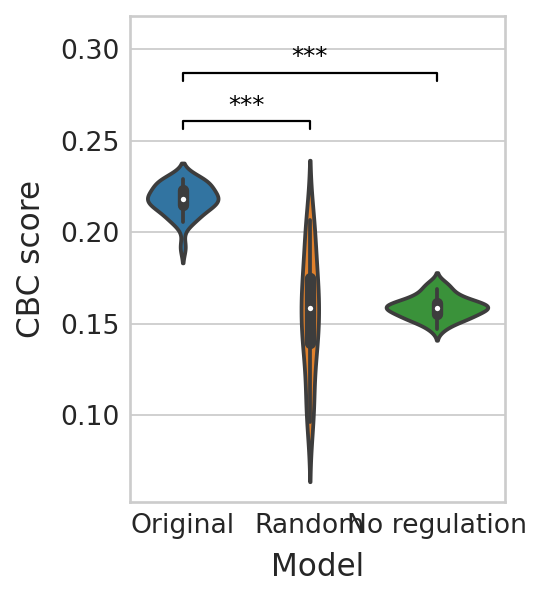

In [20]:
df = pd.DataFrame(
    {
        "CBC score":  score_v0 + score_v + score_v2,
        "Model": ["Original"] * 30 + ["Random"] * 30 + ["No regulation"] * 30
    }
)
    
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.violinplot(data=df, x="Model", y="CBC score", ax=ax)

    ttest_res = ttest_ind(score_v0, score_v, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = ttest_ind(score_v0, score_v2, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.95
    )
    
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'CBC_score_GRN.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

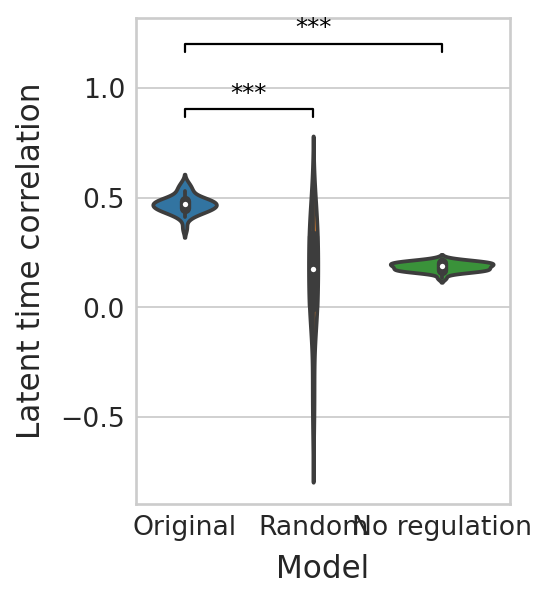

In [21]:
df = pd.DataFrame(
    {
        "Latent time correlation":  score_t0 + score_t + score_t2,
        "Model": ["Original"] * 30 + ["Random"] * 30 + ["No regulation"] * 30
    }
)
    
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 4))

    sns.violinplot(data=df, x="Model", y="Latent time correlation", ax=ax)

    ttest_res = ttest_ind(score_v0, score_v, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = ttest_ind(score_v0, score_v2, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.95
    )
    
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'cell_cycle'/ 'Time_GRN.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )